## load library

In [2]:
#python

from tqdm import tqdm,notebook
from datetime import datetime

import json

#sklearn
from sklearn.metrics import f1_score

#visualization
import matplotlib.pyplot as plt

#numpy
import numpy as np

# pytorch

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

#special loss

import madgrad
from adamp import SGDP,AdamP

#baseline

import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('/opt/ml/code/src/'))))

import warnings

warnings.filterwarnings('ignore')

from src.utils.common import get_label_counts,read_yaml
from src.model import Model
from src.dataloader import create_dataloader

from src.loss import CustomCriterion
from src.trainer import TorchTrainer
from src.utils.torch_utils import save_model
from src.utils.inference_utils import run_model


## fix seed

In [ ]:
#torch seed
torch.manual_seed(30)
torch.cuda.manual_seed(30)

#numpy seed
np.random.seed(30)

#python seed
random.seed(30)

## load base model

In [5]:
model_config = read_yaml(cfg="exp/850_475000p_96size/model.yml")
data_config = read_yaml(cfg="exp/850_475000p_96size/data.yml")

model_config = read_yaml(cfg=model_config)
data_config = read_yaml(cfg=data_config)

In [6]:
model_instance = Model(model_config, verbose=True)

idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'ReLU'] |            3           16
  1 |   1 |      1,944 | InvertedResidualv3 | [3, 1.2, 32, 1, 0, 2] |           16           32
  2 |   5 |        960 |          DWConv | [64, 1, 2, None, 'ReLU'] |           32           64
  3 |   3 |      8,640 |          DWConv | [144, 3, 2, None, 'ReLU'] |           64          144
  4 |   4 |    451,680 | InvertedResidualv3 | [5, 3.1, 80, 1, 0, 2] |          144           80
  5 |   1 |     10,496 |            Conv |          [128, 1, 1] |           80          128
  6 |   1 |          0 |   GlobalAvgPool |                   [] |          128          128
  7 |   1 |      1,170 |       FixedConv | [9, 1, 1, None, 1, None] |          128            9
Model Summary: 125 layers, 475,354 parameters,

In [20]:
module_list = []

for module in model_instance.model._modules.values():
    module_list.append(module)

In [21]:
len(module_list)

8

## make skip connection model

In [27]:
class Mymodel(nn.Module):
    def __init__(self,module_list):
        super(Mymodel,self).__init__()
        
        self.module0 = module_list[0]
        self.module1 = module_list[1]
        self.module2 = module_list[2]
        self.module3 = module_list[3]
        self.module4 = module_list[4]
        self.module5 = module_list[5]
        self.module6 = module_list[6]
        self.module7 = module_list[7]
    
    def forward(self,x):
        
        out = self.module0(x)
        
        print(out.shape)
        
        #upsample1 = nn.Upsample(scale_factor=1/8,mode='bilinear',align_corners=True)
        
        #residual = upsample1(out)
        
        out = self.module1(out)
        
        print(out.shape)
        
        out = self.module2(out) 
        
        print(out.shape)
        
        #upsample2 = nn.Upsample(scale_factor=1/2,mode='bilinear',align_corners=True)
        
        #residual2 = upsample2(out)
        
        out = self.module3(out)
        
        print(out.shape)
        
        #out = out+residual+residual2
        
        out = self.module4(out) 
        
        print(out.shape)
        
        out = self.module5(out) 
        
        print(out.shape)
        
        out = self.module6(out) 
        
        print(out.shape)
        
        out = self.module7(out)
        
        print(out.shape)

        return out

## check outputsize

In [22]:
train_dl, val_dl, test_dl = create_dataloader(data_config)

In [28]:
model = Mymodel(module_list)

In [26]:
for img,label in train_dl:
    break

In [29]:
img[2].shape

torch.Size([3, 96, 96])

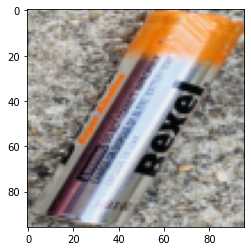

In [22]:
img2 = img[10].numpy()
img2 = np.transpose(img2,(1,2,0))
plt.imshow(img2)

In [14]:
img.shape

torch.Size([32, 3, 96, 96])

In [30]:
model.eval()

Mymodel(
  (module0): Conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=[1], bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (module1): Sequential(
    (0): InvertedResidualv3(
      (conv): Sequential(
        (0): Conv2d(16, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): SqueezeExcitation(
          (fc1): Conv2d(24, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 24, kernel_size=(1, 1), stride=(1, 1))
          (hardsigmoid): HardSigmoid()
        )
        (6): ReLU(inplace=True)
        (7): Conv

In [31]:
model(img)

torch.Size([64, 16, 48, 48])
torch.Size([64, 32, 24, 24])
torch.Size([64, 64, 12, 12])
torch.Size([64, 144, 6, 6])
torch.Size([64, 80, 3, 3])
torch.Size([64, 128, 3, 3])
torch.Size([64, 128, 1, 1])
torch.Size([64, 9, 1, 1])


tensor([[[[ 4.7279e-09]],

         [[-2.7924e-10]],

         [[ 5.3582e-09]],

         [[-3.8569e-09]],

         [[ 1.1672e-08]],

         [[ 2.3904e-11]],

         [[-3.1770e-09]],

         [[ 3.2123e-09]],

         [[-3.2296e-09]]],


        [[[ 5.7445e-09]],

         [[-2.7753e-10]],

         [[ 3.6335e-09]],

         [[-4.3974e-09]],

         [[ 7.7330e-09]],

         [[ 1.7039e-09]],

         [[-2.4270e-09]],

         [[ 2.1052e-09]],

         [[-1.9651e-09]]],


        [[[ 2.5972e-08]],

         [[-2.9871e-09]],

         [[ 1.3706e-08]],

         [[-1.5449e-08]],

         [[ 4.1136e-08]],

         [[-1.8115e-10]],

         [[-1.1647e-08]],

         [[ 9.4836e-09]],

         [[-1.6839e-08]]],


        [[[ 1.2700e-08]],

         [[-1.6768e-09]],

         [[ 5.9784e-09]],

         [[-8.0034e-09]],

         [[ 1.5343e-08]],

         [[ 6.7134e-09]],

         [[-3.2692e-09]],

         [[ 3.7905e-09]],

         [[-7.4153e-09]]],


        [[[ 2.4461e-

## training skip connection model

In [ ]:
train_dl, val_dl, test_dl = create_dataloader(data_config)

In [14]:
model = Mymodel(module_list)

model_instance.model = model

model_instance.model = model_instance.model.to(device)

In [ ]:
log_dir = os.path.join("exp", datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
os.makedirs(log_dir, exist_ok=True)

In [ ]:
log_dir = 'exp/850_475000p_96size'

In [ ]:
log_dir

In [ ]:
#basic hyperparameter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_path = os.path.join(data_config["DATA_PATH"], "train")
model_path = os.path.join(log_dir, "best.pt")

# Create optimizer, scheduler, criterion
optimizer = torch.optim.SGD(
    model_instance.model.parameters(), lr=0.1, momentum=0.9
)

#optimizer = torch.optim.Adam(
    #model_instance.model.parameters(), lr=0.1
#)


#optimizer= madgrad.MADGRAD(model_instance.model.parameters(),lr=0.1,momentum=0.9)

#optimizer = SGDP(model_instance.model.parameters(), lr=0.1, momentum=0.9, nesterov=True)

#optimizer = AdamP(model_instance.model.parameters(), lr=0.1, betas=(0.9, 0.999), weight_decay=1e-2)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=data_config["INIT_LR"],
    steps_per_epoch=len(train_dl),
    epochs=200,
    pct_start=0.05,
)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40,50,60,70,80,90,100], gamma=0.5)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)

criterion = CustomCriterion(
    samples_per_cls=get_label_counts(train_path)
    if data_config["DATASET"] == "TACO"
    else None,
    device=device,
    #loss_type="weighted"
    #loss_type="customloss"
    #loss_type="label_smoothing"
)


# Amp loss scaler
scaler = (
    torch.cuda.amp.GradScaler() if data_config['FP16'] and device != torch.device("cpu") else None
)
#scaler= None

In [9]:
#define test function

@torch.no_grad()
def test(model,test_dataloader):
    """Test model.

    Args:
        test_dataloader: test data loader module which is a iterator that returns (data, labels)

    Returns:
        loss, f1, accuracy
    """

    #n_batch = _get_n_batch_from_dataloader(test_dataloader)

    running_loss = 0.0
    preds = []
    gt = []
    correct = 0
    total = 0

    num_classes = 9
    label_list = [i for i in range(num_classes)]

    pbar = notebook.tqdm(enumerate(test_dataloader), total=len(test_dataloader))
    model.to(device)
    model.eval()
    for batch, (data, labels) in pbar:
        data, labels = data.to(device), labels.to(device)

        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model(data)
        else:
            outputs = model(data)
        outputs = torch.squeeze(outputs)
        running_loss += criterion(outputs, labels).item()

        _, pred = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

        preds += pred.to("cpu").tolist()
        gt += labels.to("cpu").tolist()
        pbar.update()
        pbar.set_description(
            f" Val: {'':5} Loss: {(running_loss / (batch + 1)):.3f}, "
            f"Acc: {(correct / total) * 100:.2f}% "
            f"F1(macro): {f1_score(y_true=gt, y_pred=preds, labels=label_list, average='macro', zero_division=0):.2f}"
        )
    loss = running_loss / len(test_dataloader)
    accuracy = correct / total
    f1 = f1_score(
        y_true=gt, y_pred=preds, labels=label_list, average="macro", zero_division=0
    )
    
    return loss, f1, accuracy

In [13]:
#change half tensor model

model_instance.model = torch.nn.DataParallel(model_instance.model)

In [17]:
#basic training

best_test_acc = -1.0
best_test_f1 = -1.0

num_classes = 9

label_list = [i for i in range(num_classes)]

for epoch in range(n_epoch):
    running_loss, correct, total = 0.0, 0, 0
    preds, gt = [], []
    pbar = notebook.tqdm(enumerate(train_dl), total=len(train_dl))
    model_instance.model.train()
    for batch, (data, labels) in pbar:
        
        data, labels = data.to(device), labels.to(device)

        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model_instance.model(data)
        else:
            outputs = model_instance.model(data)
        outputs = torch.squeeze(outputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        scheduler.step()

        _, pred = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        preds += pred.to("cpu").tolist()
        gt += labels.to("cpu").tolist()

        running_loss += loss.item()
        pbar.update()
        pbar.set_description(
            f"Train: [{epoch + 1:03d}] "
            f"Loss: {(running_loss / (batch + 1)):.3f}, "
            f"Acc: {(correct / total) * 100:.2f}% "
            f"F1(macro): {f1_score(y_true=gt, y_pred=preds, labels=label_list, average='macro', zero_division=0):.2f}"
        )
    pbar.close()

    _, test_f1, test_acc = test(
        model=model_instance.model, test_dataloader=val_dl
    )
    if best_test_f1 > test_f1:
        continue
    best_test_acc = test_acc
    best_test_f1 = test_f1
    print(f"Model saved. Current best test f1: {best_test_f1:.3f}")
    save_model(
        model=model_instance.model,
        path=model_path,
        data=data,
        device=device,
    )


Model saved. Current best test f1: 0.134



Model saved. Current best test f1: 0.191



Model saved. Current best test f1: 0.238



Model saved. Current best test f1: 0.250



Model saved. Current best test f1: 0.271



Model saved. Current best test f1: 0.317



Model saved. Current best test f1: 0.319



Model saved. Current best test f1: 0.323



Model saved. Current best test f1: 0.328



Model saved. Current best test f1: 0.353



Model saved. Current best test f1: 0.367



Model saved. Current best test f1: 0.388



Model saved. Current best test f1: 0.389



Model saved. Current best test f1: 0.393



Model saved. Current best test f1: 0.395



Model saved. Current best test f1: 0.395



Model saved. Current best test f1: 0.407



Model saved. Current best test f1: 0.409



Model saved. Current best test f1: 0.415



Model saved. Current best test f1: 0.445



Model saved. Current best test f1: 0.456



Model saved. Current best test f1: 0.461



Model saved. Current best test f1: 0.464



Model saved. Current best test f1: 0.474



Model saved. Current best test f1: 0.475



Model saved. Current best test f1: 0.475



Model saved. Current best test f1: 0.475


KeyboardInterrupt: 

## mixup and cutmix training

In [15]:
def mixup_data(x, y, alpha=1.0, use_cuda=False):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [14]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [15]:
def CutMix_two(input,target,cutmix_prob,beta=1.0):
    r = np.random.rand(1)
    if beta > 0 and r < cutmix_prob:
        lam = np.random.beta(beta, beta)
        rand_index = torch.randperm(input.size()[0]).cuda()
        target_a = target
        target_b = target[rand_index]
        bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
        input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
        return input,lam,target_a,target_b,True
    else:
        lam = np.random.beta(beta, beta)
        return input,lam,target,target,False

In [16]:
#mixup training

best_test_acc = -1.0
best_test_f1 = -1.0

num_classes = 9

label_list = [i for i in range(num_classes)]

for epoch in range(n_epoch):
    running_loss, correct, total = 0.0, 0, 0
    preds, gt = [], []
    pbar = notebook.tqdm(enumerate(train_dl), total=len(train_dl))
    model_instance.model.train()
    for batch, (data, labels) in pbar:
        
        data,label_a,label_b,lam = mixup_data(data,labels,alpha=1.0)
        
        data, labels, label_a, label_b = data.to(device), labels.to(device), label_a.to(device), label_b.to(device)
        

        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model_instance.model(data)
        else:
            outputs = model_instance.model(data)
        outputs = torch.squeeze(outputs)
        #loss = criterion(outputs, labels)
        loss = criterion(outputs, label_a) * lam + criterion(outputs, label_b)* (1-lam)

        optimizer.zero_grad()

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        scheduler.step()

        _, pred = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        preds += pred.to("cpu").tolist()
        gt += labels.to("cpu").tolist()

        running_loss += loss.item()
        pbar.update()
        pbar.set_description(
            f"Train: [{epoch + 1:03d}] "
            f"Loss: {(running_loss / (batch + 1)):.3f}, "
            f"Acc: {(correct / total) * 100:.2f}% "
            f"F1(macro): {f1_score(y_true=gt, y_pred=preds, labels=label_list, average='macro', zero_division=0):.2f}"
        )
    pbar.close()

    _, test_f1, test_acc = test(
        model=model_instance.model, test_dataloader=val_dl
    )
    if best_test_f1 > test_f1:
        continue
    best_test_acc = test_acc
    best_test_f1 = test_f1
    print(f"Model saved. Current best test f1: {best_test_f1:.3f}")
    save_model(
        model=model_instance.model,
        path=model_path,
        data=data,
        device=device,
    )

NameError: name 'mixup_data' is not defined

In [16]:
#cutmix training

best_test_acc = -1.0
best_test_f1 = -1.0

num_classes = 9

label_list = [i for i in range(num_classes)]

for epoch in range(n_epoch):
    running_loss, correct, total = 0.0, 0, 0
    preds, gt = [], []
    pbar = notebook.tqdm(enumerate(train_dl), total=len(train_dl))
    model_instance.model.train()
    for batch, (data, labels) in pbar:
        
        data,lam,target_a,target_b,cut = CutMix_two(data,labels,cutmix_prob=0.5)
        
        data, labels = data.to(device), labels.to(device)

        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model_instance.model(data)
        else:
            outputs = model_instance.model(data)
        outputs = torch.squeeze(outputs)
        
        if cut:
            target_a = target_a.to(device)
            target_b = target_b.to(device)
            loss = criterion(outputs, target_a) * lam + criterion(outputs, target_b)* (1-lam)
        else:
            target_a = target_a.to(device)
            loss = criterion(outputs, target_a)

        optimizer.zero_grad()

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        scheduler.step()

        _, pred = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        preds += pred.to("cpu").tolist()
        gt += labels.to("cpu").tolist()

        running_loss += loss.item()
        pbar.update()
        pbar.set_description(
            f"Train: [{epoch + 1:03d}] "
            f"Loss: {(running_loss / (batch + 1)):.3f}, "
            f"Acc: {(correct / total) * 100:.2f}% "
            f"F1(macro): {f1_score(y_true=gt, y_pred=preds, labels=label_list, average='macro', zero_division=0):.2f}"
        )
    pbar.close()

    _, test_f1, test_acc = test(
        model=model_instance.model, test_dataloader=val_dl
    )
    if best_test_f1 > test_f1:
        continue
    best_test_acc = test_acc
    best_test_f1 = test_f1
    print(f"Model saved. Current best test f1: {best_test_f1:.3f}")
    save_model(
        model=model_instance.model,
        path=model_path,
        data=data,
        device=device,
    )


Model saved. Current best test f1: 0.167



Model saved. Current best test f1: 0.177



Model saved. Current best test f1: 0.194



Model saved. Current best test f1: 0.216



Model saved. Current best test f1: 0.218



Model saved. Current best test f1: 0.252



Model saved. Current best test f1: 0.257



Model saved. Current best test f1: 0.268



Model saved. Current best test f1: 0.275



Model saved. Current best test f1: 0.276



Model saved. Current best test f1: 0.297



Model saved. Current best test f1: 0.304



Model saved. Current best test f1: 0.325



Model saved. Current best test f1: 0.334



Model saved. Current best test f1: 0.358



Model saved. Current best test f1: 0.374



Model saved. Current best test f1: 0.374



Model saved. Current best test f1: 0.378



Model saved. Current best test f1: 0.379



Model saved. Current best test f1: 0.383



Model saved. Current best test f1: 0.396



Model saved. Current best test f1: 0.399



Model saved. Current best test f1: 0.404



Model saved. Current best test f1: 0.405



Model saved. Current best test f1: 0.412


KeyboardInterrupt: 

## basic inference

In [39]:
#imagefolder function

CLASSES = ['Battery', 'Clothing', 'Glass', 'Metal', 'Paper', 'Paperpack', 'Plastic', 'Plasticbag', 'Styrofoam']

class CustomImageFolder(ImageFolder):
    """ImageFolder with filename."""

    def __getitem__(self, index):
        img_gt = super(CustomImageFolder, self).__getitem__(index)
        fdir = self.imgs[index][0]
        fname = fdir.rsplit(os.path.sep, 1)[-1]
        return (img_gt + (fname,))

In [40]:
#prepare dataloader

def get_dataloader(img_root: str, data_config: str) -> DataLoader:
    """Get dataloader.

    Note:
	Don't forget to set normalization.
    """
    # Load yaml
    data_config = read_yaml(data_config)

    transform_test_args = data_config["AUG_TEST_PARAMS"] if data_config.get("AUG_TEST_PARAMS") else None
    # Transformation for test
    transform_test = getattr(
        __import__("src.augmentation.policies", fromlist=[""]),
        data_config["AUG_TEST"],
    )(dataset=data_config["DATASET"], img_size=data_config["IMG_SIZE"])

    dataset = CustomImageFolder(root=img_root, transform=transform_test)
    dataloader = DataLoader(
	dataset=dataset,
	batch_size=1,
	num_workers=8
    )
    return dataloader

In [41]:
@torch.no_grad()
def inference(model, dataloader, dst_path: str):
    result = {}
    model = model.to(device)
    model.eval()
    submission_csv = {}
    for img, _, fname in dataloader:
        img = img.to(device)
        pred, enc_data = run_model(model, img)
        pred = torch.argmax(pred)
        submission_csv[fname[0]] = CLASSES[int(pred.detach())]

    result["macs"] = enc_data
    result["submission"] = submission_csv
    j = json.dumps(result, indent=4)
    save_path = os.path.join(dst_path, 'submission.csv')
    with open(save_path, 'w') as outfile:
        json.dump(result, outfile)

In [42]:
dst='/opt/ml/'
#model_weight = 'exp/2021-06-09_21-47-13/best.pt'
#model_config ='exp/0.5177_100epoch_1120/model.yml'
data_config = 'exp/0.5177_100epoch_1120/data.yml'
img_root = 'input/data/test'

In [47]:
# prepare datalaoder
dataloader = get_dataloader(img_root=img_root, data_config=data_config)

# inference
inference(model_instance.model, dataloader, dst)